In [5]:
import os
import re
import uproot
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
%matplotlib widget

In [6]:
filename = os.path.expandvars("$HOME/Software/WCSimFQTuningTools/Time/PyfiTQun/tpdf_histograms.h5")
filename = os.path.expandvars("$LUSTRE/Time/e-/tuning/pyfitqun/tpdf_histograms.h5")

In [8]:
# read momentum values and define momentum bins
with tb.open_file(filename) as f: momenta_keys = list(f.root.direct._v_children)

Selecting p = 400.511 (MeV/c)


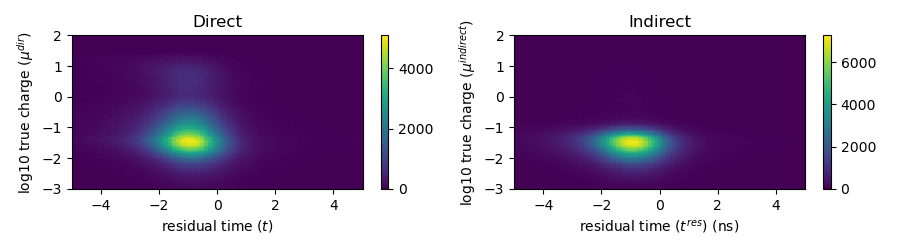

In [9]:
# read 2D histogram
p = np.random.choice(momenta_keys)
print(f"Selecting p = {p[2:]} (MeV/c)")

with tb.open_file(filename) as f:
    Hdirect   = getattr(  f.root.direct, p).read()
    Hindirect = getattr(f.root.indirect, p).read()

    tresbins = f.root.bins.tres.read()
    μbins    = f.root.bins.μ   .read()

plt.figure(figsize=[9, 2.5])

plt.subplot(121)
plt.title("Direct")
plt.pcolormesh(tresbins, μbins, Hdirect.T)
plt.xlabel(r"residual time ($t$)")
plt.ylabel(r"log10 true charge ($\mu^{dir}$)")
plt.colorbar()

plt.subplot(122)
plt.title("Indirect")
plt.pcolormesh(tresbins, μbins, Hindirect.T)
plt.xlabel(r"residual time ($t^{res}$) (ns)")
plt.ylabel(r"log10 true charge ($\mu^{indirect}$)")
plt.colorbar()

plt.tight_layout()

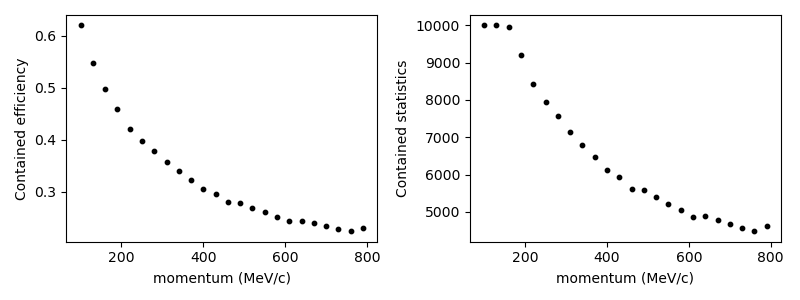

In [10]:
with tb.open_file(filename) as f: events = f.root.events.read()

ps        = events[:, 0]
contained = events[:, 1]
total     = events[:, 2] 

efficiency = contained/total

plt.figure(figsize=[8, 3])

plt.subplot(121)
plt.scatter(ps, efficiency, s=10, color="k")
plt.xlabel("momentum (MeV/c)")
plt.ylabel("Contained efficiency")

plt.subplot(122)
plt.scatter(ps, contained, s=10, color="k")
plt.xlabel("momentum (MeV/c)")
plt.ylabel("Contained statistics")

plt.tight_layout()

### Indirect Time PDF

In [12]:
from scipy.optimize import curve_fit

# function to fit
def indirect_timepdf(t, delta, sig, gamma):
    out = np.zeros(len(t))

    dt = t - delta
    A = 1./(np.sqrt(np.pi/2.)*sig + 2*gamma)

    sel = dt<0
    out[sel]  = A*np.exp(-dt[sel]**2/(2.*sig**2))
    out[~sel] = A*(dt[~sel]/gamma + 1.)*np.exp(-dt[~sel]/gamma)
    
    return out

In [13]:
# read indirect distributions
timepdfs = np.zeros((len(momenta_keys), len(tresbins)-1))
for pi, p_key in enumerate(momenta_keys, 0):
    # read 2D histogram for this momentum
    with tb.open_file(filename) as f:
        H = getattr(f.root.indirect, p_key).read()
        
    # project and normalize
    h    = H.sum(axis=1)
    norm = np.sum(h*(tresbins[1:]-tresbins[:-1]))
    timepdfs[pi] = h/norm

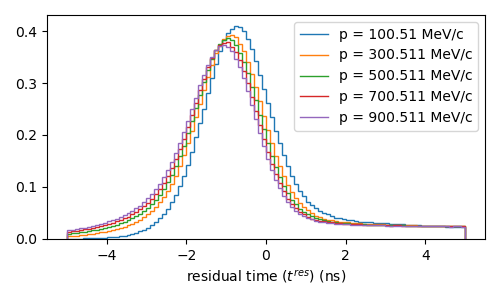

In [14]:
plt.figure(figsize=[5, 3])

for pi in range(len(timepdfs))[::2]:
    h = timepdfs[pi]
    plt.stairs(h, tresbins, label=f"p = {momenta_keys[pi][2:]} MeV/c")

plt.xlabel(r"residual time ($t^{res}$) (ns)")
plt.legend()
plt.tight_layout()

In [15]:
# merge momentum distributions and fit
tress = (tresbins[1:] + tresbins[:-1])/2.
pdf = np.zeros(len(tresbins)-1)
for tpdf in timepdfs: pdf += tpdf
norm = np.sum(pdf*(tresbins[1:]-tresbins[:-1]))
pdf  = pdf/norm
params, cov = curve_fit(indirect_timepdf, tress, pdf)

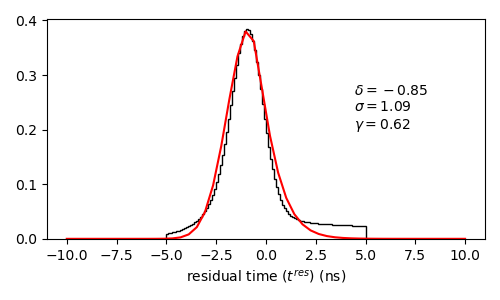

In [19]:
fig = plt.figure(figsize=[5, 3])
ax = fig.add_subplot(111)

ax.stairs(pdf, tresbins, color="k", label=f"p = {momenta_keys[pi][2:]} MeV/c")

ts   = np.linspace(tress[0], tress[-1], 100)
ts   = np.linspace(-10, 10)
pdf_ = indirect_timepdf(ts, *params)
ax.plot(ts, pdf_, color="r")

text = fr"$\delta = {round(params[0], 2)}$" + "\n" \
     + fr"$\sigma = {round(params[1], 2)}$" + "\n" \
     + fr"$\gamma = {round(params[2], 2)}$"


ax.text(0.7, 0.5, text, transform=ax.transAxes)

ax.set_xlabel(r"residual time ($t^{res}$) (ns)")
fig.tight_layout()

In [20]:
indirect_timepdf(, *params)

<function __main__.indirect_timepdf(t, delta, sig, gamma)>